# Procesamiento digital de imágenes

# Filtro maestro

## Alumna: Salma Patricia Gutiérrez Rivera

In [14]:
# Librerías que voy a usar
import numpy as np
import matplotlib.pyplot as plt
import cv2
import filtros # Mis funciones

__1.__ Modificar las funciones vistas en clase que generan filtros de tipo ideal de la forma pasa-bajos, pasa-altos, pasa-bandas y rechazo de bandas, generalizándolas para que se indique si el filtro es ideal, Gaussiano o de Butterworth.

In [15]:
def kernel_pasabajos(M, N, d0 = 15, forma = 0, n = 1):
    """forma = 0 para kernel ideal, 1 para gaussiano y cualquier otro para Butterworth."""
    V, U = filtros.hacer_meshgrid(M, N)
    # Distancias al cuadrado
    D = np.square(U - 0.5 * M) + np.square(V - 0.5 * N)
    
    if forma == 0:
        kernel = np.where(D <= d0**2, 1, 0)
    elif forma == 1:
        kernel = np.exp(-0.5 * D / d0**2)
    else:
        kernel = 1.0 / (1.0 + (D / d0**2)**n)
    
    return kernel

In [16]:
def kernel_pasaaltos(M, N, d0 = 15, forma = 0, n = 1):
    """forma = 0 para kernel ideal, 1 para gaussiano y cualquier otro para Butterworth."""
    kernel = 1.0 - kernel_pasabajos(M, N, d0, forma, n)
    
    return kernel

In [17]:
def kernel_rechazabandas(M, N, c0 = 20, w = 10, forma = 0, n = 1):
    """forma = 0 para kernel ideal, 1 para gaussiano y cualquier otro para Butterworth."""
    V, U = filtros.hacer_meshgrid(M, N)
    # Distancias al cuadrado
    D = np.square(U - 0.5 * M) + np.square(V - 0.5 * N)
    
    if forma == 0:
        provisional1 = np.where(D >= c0 - 0.5 * w, 1, 0)
        provisional2 = np.where(D >= c0 + 0.5 * w, 1, 0)
        provisional3 = provisional1 + provisional2
        kernel = np.where(provisional3 == 0, 1, 0)
    elif forma == 1:
        kernel = 1.0 - np.exp(-((D - c0**2) / (w * D))**2)
    else:
        kernel = 1.0 / (1.0 + ((D * w**2) / (D - c0**2))**n)
    
    return kernel

In [18]:
def kernel_pasabandas(M, N, c0 = 20, w = 10, forma = 0, n = 1):
    """forma = 0 para kernel ideal, 1 para gaussiano y cualquier otro para Butterworth."""
    kernel = 1.0 - kernel_rechazabandas(M, N, c0, w, forma, n)
    
    return kernel

Para una muestra del uso de estos filtros, ir a prueba_filtros.ipynb o prueba_filtros.pdf

__2.__ Hacer una función que diseñe filtros notch ideales, de Gauss o de Butterworth.

In [19]:
def kernel_ideal_notch(M, N, centro, d0):
    u_k = centro[0]
    v_k = centro[1]
    V, U = filtros.hacer_meshgrid(M, N)
    
    D_k = np.square(U - 0.5 * M - u_k) + np.square(V - 0.5 * N - v_k)
    D_mk = np.square(U - 0.5 * M + u_k) + np.square(V - 0.5 * N + v_k)
    H_k = np.where(D_k <= d0**2, 0, 1) # Primer pasaaltos
    H_mk = np.where(D_mk <= d0**2, 0, 1) # Segundo pasaaltos
    kernel = H_k * H_mk
    
    return kernel

In [20]:
def kernel_gaussiano_notch(M, N, centro, d0):
    u_k = centro[0]
    v_k = centro[1]
    V, U = filtros.hacer_meshgrid(M, N)
    
    D_k = np.square(U - 0.5 * M - u_k) + np.square(V - 0.5 * N - v_k)
    D_mk = np.square(U - 0.5 * M + u_k) + np.square(V - 0.5 * N + v_k)
    H_k = 1 - np.exp(-(0.5 / d0**2) * D_k) # Primer pasaaltos
    H_mk = 1 - np.exp(-(0.5 / d0**2) * D_mk) # Segundo pasaaltos
    kernel = H_k * H_mk
    
    return kernel

In [21]:
def kernel_butterworth_notch(M, N, centro, d0, n):
    u_k = centro[0]
    v_k = centro[1]
    V, U = filtros.hacer_meshgrid(M, N)
    
    D_k = np.square(U - 0.5 * M - u_k) + np.square(V - 0.5 * N - v_k)
    D_mk = np.square(U - 0.5 * M + u_k) + np.square(V - 0.5 * N + v_k)
    H_k = np.divide(D_k**n, D_k**n + d0**(2*n)) # Primer pasaaltos
    H_mk = np.divide(D_mk**n, D_mk**n + d0**(2*n)) # Segundo pasaaltos
    kernel = H_k * H_mk
    
    return kernel

In [58]:
def kernel_notch(M, N, d0, centro = (0, 0), forma = 0, pasa = 0, n = 1.0):
    """Filtro notch. 
    forma = 0 para ideal, 1 para gaussiano y cualquier otro valor para butterworth.
    pasa = 0 para notchreject, 1 para notchpass.
    centro y radio son los del notch. notch simétrico automático.
    Especificar n solo para butterworth"""
    
    if forma == 0:
        kernel_prov = kernel_ideal_notch(M, N, centro, d0)
    elif forma == 1:
        kernel_prov = kernel_gaussiano_notch(M, N, centro, d0)
    else:
        kernel_prov = kernel_butterworth_notch(M, N, centro, d0, n)
        
    kernel = pasa + (-1)**pasa * kernel_prov
    
    return kernel

__3.__ Hacer una función maestra que diseñe filtros indicando: Tipo de filtro (pasa bajos, pasa altos, pasa bandas, rechazo de bandas, notch), con que forma del filtro (ideal, Gaussiano, Buttherworth) y los parámetros necesarios para realizar el diseño.

In [45]:
def kernel_maestro(M, N, d0 = 15, centro = (0,0), pasa = 0, n = 1, c0 = 20, w = 10, tipo = 'pasabajos', forma = 0):
    """Me parece que lo mejor es llamar a los argumentos con todo y nombre.
    Usar solo strings permitidos para el argumento 'tipo' o no me hago responsable :3"""
    if tipo == 'pasabajos':
        kernel = kernel_pasabajos(M, N, d0, forma, n)
    elif tipo == 'pasaaltos':
        kernel = kernel_pasaaltos(M, N, d0, forma, n)
    elif tipo == 'pasabandas':
        kernel = kernel_pasabandas(M, N, c0, w, forma, n)
    elif tipo == 'rechazabandas':
        kernel = kernel_rechazabandas(M, N, c0, w, forma, n)
    else: # Asume notch
        kernel = kernel_notch(M, N, d0, centro, forma, pasa, n)
        
    return kernel

__4.__ Una función que diseñe y aplique el filtro a una imagen.

In [32]:
def filtrar(imagen, d0 = 15, centro = (0,0), pasa = 0, n = 1, c0 = 20, w = 10, tipo = 'pasabajos', forma = 0):
    M, N = imagen.shape
    kernel = kernel_maestro(M, N, d0, centro, pasa, n, c0, w, tipo, forma)
    
    return filtros.aplicar_filtro(imagen, kernel)

__5.__ Aplique a la imagen que se llama mama.tif los siguientes filtros:

Filtro pasa bajos ideal con wc=64

In [33]:
mama = cv2.imread("imagenes/mama.tif", 0)

In [34]:
filtro1 = filtrar(mama, 64)

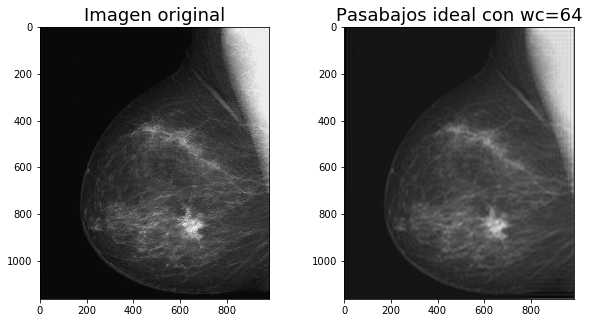

In [36]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro1, cmap = 'gray')
plt.title('Pasabajos ideal con wc=64', size = 18);

Filtro pasa bajos butt con wc=64, orden=2

In [38]:
filtro2 = filtrar(mama, 64.0, n = 2.0, forma = 2)

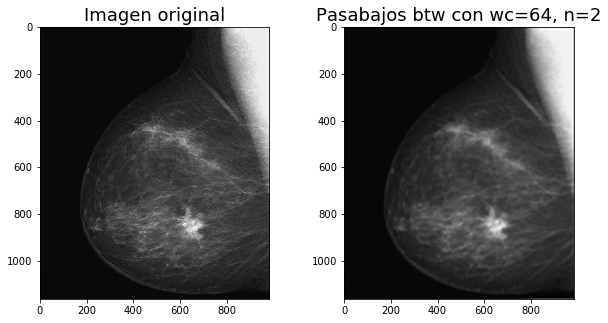

In [39]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro2, cmap = 'gray')
plt.title('Pasabajos btw con wc=64, n=2', size = 18);

Filtro pasa bajos gauss con wc=64

In [40]:
filtro3 = filtrar(mama, 64.0, forma = 1)

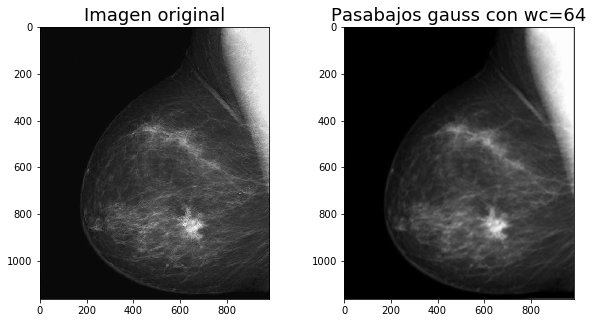

In [41]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro3, cmap = 'gray')
plt.title('Pasabajos gauss con wc=64', size = 18);

Filtro pasa altos gauss con wc=64

In [42]:
filtro4 = filtrar(mama, 64.0, tipo = 'pasaaltos', forma = 1)

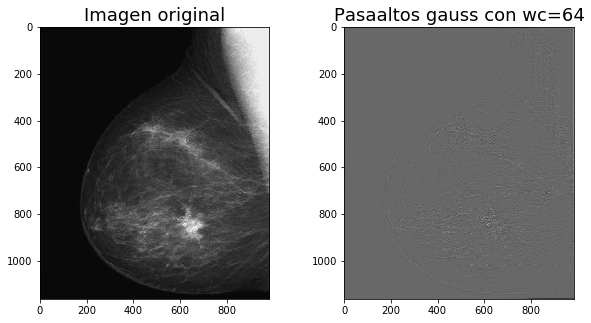

In [43]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro4, cmap = 'gray')
plt.title('Pasaaltos gauss con wc=64', size = 18);

Filtro pasa bandas gauss con wc1=54, wc2=74

In [46]:
filtro5 = filtrar(mama, c0 = 74.0, w = 54.0, tipo = 'pasabandas', forma = 1)

/home/quaque/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


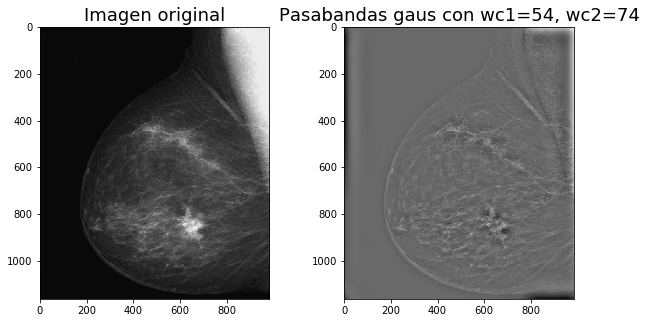

In [47]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro5, cmap = 'gray')
plt.title('Pasabandas gaus con wc1=54, wc2=74', size = 18);

Filtro rechazo de bandas gauss con wc1=54, wc2=74

In [48]:
filtro6 = filtrar(mama, c0 = 74.0, w = 54.0, tipo = 'rechazabandas', forma = 1)

/home/quaque/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


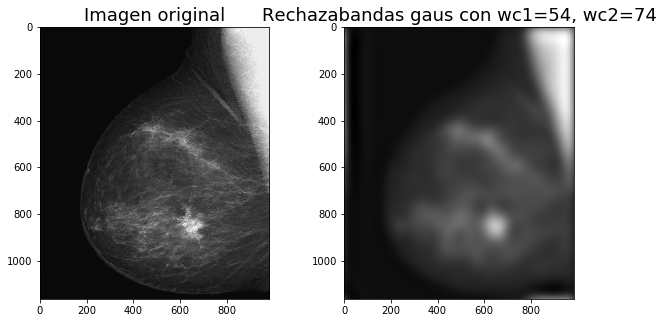

In [49]:
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(mama, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(filtro6, cmap = 'gray')
plt.title('Rechazabandas gaus con wc1=54, wc2=74', size = 18);

__6.__ A las figuras FigP0405(HeadCT_corrupted).tif y a RadiografiaRuidoCoherente.jpg intente quitar el ruido coherente que se observa, detalle el procedimiento que realizó y los resultados que obtuvo

Comienzo con el cráneo.

In [50]:
craneo = cv2.imread('imagenes/FigP0405(HeadCT_corrupted).tif', 0)
craneo_dft = filtros.imagen_dft(craneo)

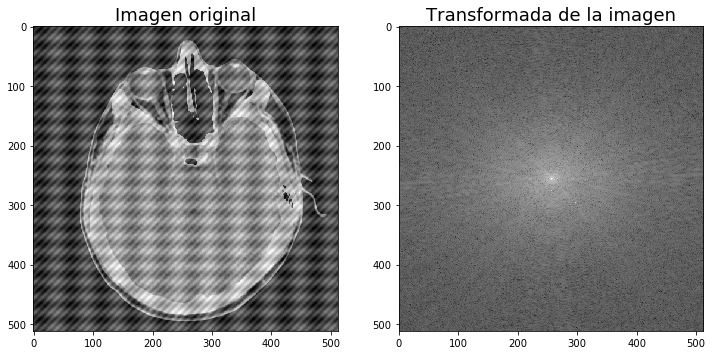

In [54]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(craneo, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
#plt.xlim(290, 310)
#plt.ylim(290, 310)
plt.imshow(craneo_dft, cmap = 'gray')
plt.title('Transformada de la imagen', size = 18);

En la transformada de la imagen, puedo observar, a simple vista, cuatro puntitos. Voy tratar de quitarlos con filtros notch, calculando la ubicación de los puntos _a ojímetro_.

In [59]:
craneo_filt1 = filtrar(craneo, 15, (0, 25), tipo = 'notch')

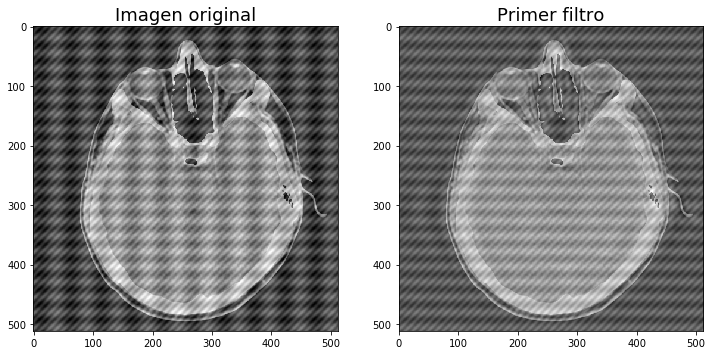

In [60]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(craneo, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(craneo_filt1, cmap = 'gray')
plt.title('Primer filtro', size = 18);

Se quitó el ruido vertical.

In [62]:
craneo_filt2 = filtrar(craneo_filt1, 5, (20, 0), tipo = 'notch')

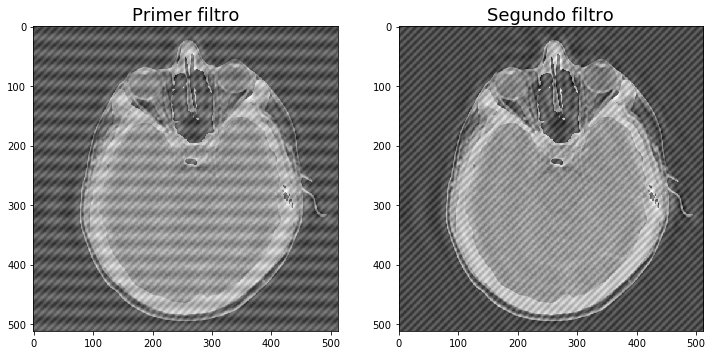

In [65]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(craneo_filt1, cmap = 'gray')
plt.title('Primer filtro', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(craneo_filt2, cmap = 'gray')
plt.title('Segundo filtro', size = 18);

Se eliminó el ruido horizontal.

In [64]:
craneo_filt3 = filtrar(craneo_filt2, 15, (46, 46), tipo = 'notch')

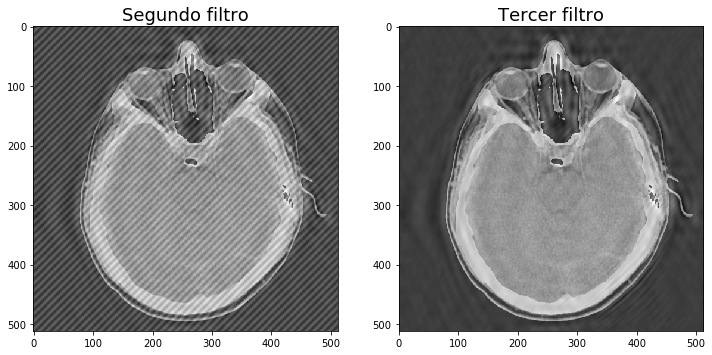

In [66]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(craneo_filt2, cmap = 'gray')
plt.title('Segundo filtro', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(craneo_filt3, cmap = 'gray')
plt.title('Tercer filtro', size = 18);

Se quitó el ruido diagonal.

Continúo con las costillas.

In [67]:
huesos = cv2.imread('imagenes/RadiografiaRuidoCoherente.jpg', 0)
huesos_dft = filtros.imagen_dft(huesos)

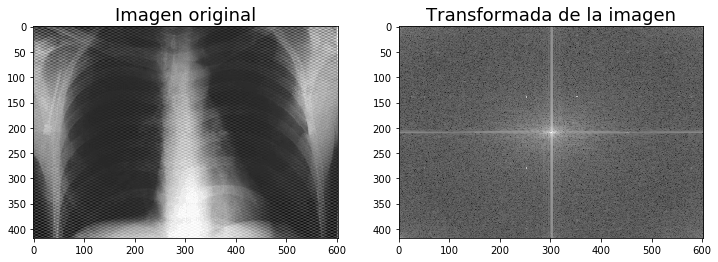

In [68]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(huesos, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
#plt.xlim(200, 300)
#plt.ylim(100, 150)
plt.imshow(huesos_dft, cmap = 'gray')
plt.title('Transformada de la imagen', size = 18);

Aquí hay cuatro puntitos muy obvios.

In [69]:
huesos_filt1 = filtrar(huesos, 20, (50, 101), tipo = 'notch')

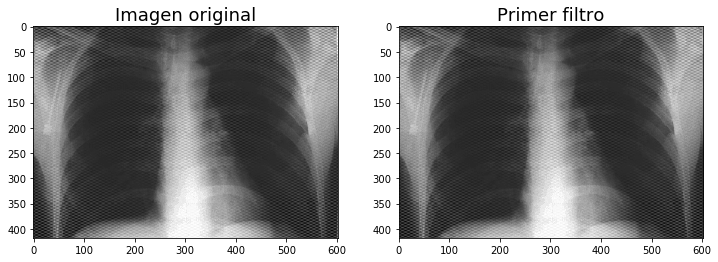

In [70]:
fig = plt.figure(figsize = (12, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(huesos, cmap = 'gray')
plt.title('Imagen original', size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(huesos_filt1, cmap = 'gray')
plt.title('Primer filtro', size = 18);